# 5TF078 Deep Learning Course
#Erik Vodopivec Forsman
## Excercise 4 Sentiment analysis on IMDB
Created by Tomas Nordström, Umeå University

Revisions:
* 2023-11-24 Initial version based on earlier versions of this Excercise /ToNo
* 2023-12-03 Prepare for release /ToNo
* 2023-12-04 Work around a bug that made installing KerasNLP force a non-GPU version of tensorflow /ToNo
* 2023-12-07 Since two days there is is a bug in keras-nlp.git "No module named 'keras_nlp.models.electra'", so an updated installation method is implemented. /ToNo
* 2024-01-31 A new way of installing keras_nlp, as the previous one began to crash in the last weeks.
* 2024-03-24 Updated tests for Kaggle. /Tomas
* 2024-05-05 Added missing "import time" & "import os"; Forced a loading of dev versions of KEras/TF as current version do not handle LSTM well. /Tomas

Much of this is based on the KerasNLP getting started documentation:
https://keras.io/guides/keras_nlp/getting_started/

Other code examples used:
* https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/first_edition/6.2-understanding-recurrent-neural-networks.ipynb
* https://keras.io/examples/nlp/fnet_classification_with_keras_nlp/
* https://www.tensorflow.org/text/tutorials/text_classification_rnn
* https://keras.io/examples/nlp/text_classification_from_scratch/


In [1]:
import sys
import os
import time

### Is this notebook running on Colab?
IS_COLAB = "google.colab" in sys.modules

### Is this notebook running on Kaggle?
# Fool Kaggle into making kaggle_secrets avaiable
try:
    import kaggle_secrets
except ImportError as e:
    pass
# Now we can test for Kaggle
IS_KAGGLE = "kaggle_secrets" in sys.modules

# First we initilize our Python environment

In [ ]:
import sys
import os
import time

### Is this notebook running on Colab?
IS_COLAB = "google.colab" in sys.modules

### Is this notebook running on Kaggle?
# Fool Kaggle into making kaggle_secrets avaiable
try:
    import kaggle_secrets
except ImportError as e:
    pass
# Now we can test for Kaggle
IS_KAGGLE = "kaggle_secrets" in sys.modules

# As of 2024-05-05 older Keras versions is having problem with our LSTM code, and we need to install the dev version of Keras and TF
# This is true for both Colab (Keras 2.15) and Kaggle (Keras 3.0.5)
if IS_COLAB or IS_KAGGLE:
    start = time.time()
    # This will install KerasNLP, Keras 3.3, and TF 2.17, it takes one minute or so
    !pip3 install keras-nlp-nightly  --force-reinstall # Needs to be before the next two, can not be in the same pip for some magic reason
    !pip3 install keras-nightly tf-nightly --force-reinstall
    !pip3 install ml-dtypes==0.2.0 # Need to downgrade for the bleeding edge of tensorflow
    end = time.time()
    print(f"Time to install everything: {end - start:.1f}",)
    print("You (most likely) need to restart the runtime now!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.4/515.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.1/774.1 kB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 101.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 101.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.2 MB/s eta 0:00:00
     ━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/584.3 MB 118.4 MB/s eta 0:00:05
ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.1 MB/s eta 0:00:00


In [1]:
# Set up Keras backend
import os
os.environ["KERAS_BACKEND"] = "jax" # Also tensorflow,jax,pytorch for Keras 3.0

# Make TF less noisy
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

# Import Keras/TF libraries
import keras
print('Keras version:', keras.__version__)

import tensorflow as tf
print('TensorFlow version:', tf.__version__)

Keras version: 3.3.3
TensorFlow version: 2.16.1


In [2]:
# Test for GPU and determine what GPU we have
import os
import platform
import subprocess
gpu_name = tf.test.gpu_device_name()
if gpu_name != '':
    print('TF-GPU-devname:',tf.test.gpu_device_name())
    sys_details = tf.sysconfig.get_build_info()
    physical_devices = tf.config.list_physical_devices('GPU')
    print("Num GPUs:", len(physical_devices))
    if platform.system() == "Darwin":
        print('GPU on Mac!')
    else:
        cuda_version = sys_details["cuda_version"]
        print('TF-cuda version:',cuda_version)
        if len(physical_devices)>0:
            process = subprocess.Popen(['nvidia-smi','-L'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            print(process.communicate())
else:
    print('TF-device: Only CPU!')
    print('As long as we are using Keras and Jax, this will not affect us in this notebook!')

# Test for Jax backend
# https://github.com/google/jax/issues/971
from jax.lib import xla_bridge
print(f'Jax backend: {xla_bridge.get_backend().platform}')

TF-GPU-devname: /device:GPU:0
Num GPUs: 1
TF-cuda version: 12.3
(b'GPU 0: Tesla T4 (UUID: GPU-dfbbf697-283e-ec28-19c5-5c1070da859f)\n', b'')
Jax backend: gpu


In [3]:
# Helper libraries
import numpy as np
import pandas as pd

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

# Read in the data

The IMDb dataset consists of 50,000 movie reviews in English
(25,000 for training, 25,000 for testing) extracted from the famous Internet Movie Database, along with a simple binary target for each review indicating whether it is negative (0) or positive (1).

There are many alternatives to get the data:
* Use the Keras built in [IMDB database](https://keras.io/api/datasets/imdb/) from keras.
* Use the TensorFlow Datasets library for [IMDB reviews](https://www.tensorflow.org/datasets/catalog/imdb_reviews)
* Or as we are going to do, read the [orginal dataset](http://ai.stanford.edu/~amaas/data/sentiment/)

We use to orginal data to see how one can read data (text) files from directories directly. How one can do preprocessing on datasets. The raw data is also preferred when we later want to work with BERT as a transfer learning model. (The Keras data have already preprocessed words into integers.)

In [4]:
# Reading the database from the source
# following https://keras.io/guides/keras_nlp/getting_started/
if not os.path.exists('./aclImdb_v1.tar.gz'):
  !curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
  !tar -xf aclImdb_v1.tar.gz
  !# Remove unsupervised examples
  !rm -r aclImdb/train/unsup

print(os.listdir("./aclImdb"))
print(os.listdir("./aclImdb/train"))
print(os.listdir("./aclImdb/test"))

with open("./aclImdb/train/pos/4242_9.txt") as f:
  print (f'Example of a postive review: {f.read()}')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  6428k      0  0:00:12  0:00:12 --:--:-- 14.1M
['train', 'imdbEr.txt', 'README', 'imdb.vocab', 'test']
['urls_neg.txt', 'urls_unsup.txt', 'labeledBow.feat', 'pos', 'neg', 'urls_pos.txt', 'unsupBow.feat']
['urls_neg.txt', 'labeledBow.feat', 'pos', 'neg', 'urls_pos.txt']
Example of a postive review: I read the book and saw the movie. Both excellent. The movie is diamond among coals during this era. Liebman and Selby dominate the screen and communicate the intensity of their characters without flaw. This film should have made them stars. Shame on the studio for not putting everything they had behind this film. It could have easily been a franchise. Release on DVD is a must and a worthy remake would revive this film. Look for it in your TV guide and if you see it listed, no matter how late, watch it. Yo

In [5]:
batch_size = 32

# Load directories of text into our datasets using https://keras.io/api/data_loading/text/
raw_imdb_train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_imdb_val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)
raw_imdb_test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

print(f"Number of batches in raw_imdb_train_ds: {raw_imdb_train_ds.cardinality()}")
print(f"Number of batches in raw_imdb_val_ds: {raw_imdb_val_ds.cardinality()}")
print(f"Number of batches in raw_imdb_test_ds: {raw_imdb_test_ds.cardinality()}")

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Number of batches in raw_imdb_train_ds: 625
Number of batches in raw_imdb_val_ds: 157
Number of batches in raw_imdb_test_ds: 782


In [6]:
# Let's print a few samples.
for text_batch, label_batch in raw_imdb_train_ds.take(1):
    for i in range(3):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b'I\'ve seen tons of science fiction from the 70s; some horrendously bad, and others thought provoking and truly frightening. Soylent Green fits into the latter category. Yes, at times it\'s a little campy, and yes, the furniture is good for a giggle or two, but some of the film seems awfully prescient. Here we have a film, 9 years before Blade Runner, that dares to imagine the future as somthing dark, scary, and nihilistic. Both Charlton Heston and Edward G. Robinson fare far better in this than The Ten Commandments, and Robinson\'s assisted-suicide scene is creepily prescient of Kevorkian and his ilk. Some of the attitudes are dated (can you imagine a filmmaker getting away with the "women as furniture" concept in our oh-so-politically-correct-90s?), but it\'s rare to find a film from the Me Decade that actually can make you think. This is one I\'d love to see on the big screen, because even in a widescreen presentation, I don\'t think the overall scope of this film would receive its

Note that the raw text contains HTML break tags of the form "\<br /\>"!

We want to remove them later on.

In [7]:
# The test sentences in this exercise
test_sentences = [
  "That movie was absolutely awful",
  "The acting was a bit lacking",
  "The film was creative and surprising",
  "Absolutely fantastic!",
  "This movie is not worth the money",
  "The only positive thing with this movie is the music"
]

# Do Data Preprocessing

In [8]:
# Model constants
vocab_size = 10000
sequence_length = 500

## Set it up

In [9]:
# We will now convert the text to lowercase and remove html stuff
# Based on https://keras.io/examples/nlp/text_classification_from_scratch/

import string
import re

# Having looked at our data above, we see that the raw text contains HTML break
# tags of the form '<br />'. These tags will not be removed by the default
# standardizer (which doesn't strip HTML). Because of this, we will need to
# create a custom standardization function.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )

# Now that we have our custom standardization, we can instantiate our text
# vectorization layer. We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
preprocessing_layer = keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Now that the vocab layer has been created, call `adapt` on a text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.

# Let's make a text-only dataset (no labels):
text_ds = raw_imdb_train_ds.map(lambda x, y: x)
# Let's call `adapt` (to initialise the vocabulary on the text from the training set)
preprocessing_layer.adapt(text_ds)

# Define a function to prepare the text in a dataset (batch)
def preprocessing_text(text, label):
    text = tf.expand_dims(text, -1)
    return preprocessing_layer(text), label

In [10]:
# Get the vocabulary
voc = preprocessing_layer.get_vocabulary()
print(voc[:8])
word_index = dict(zip(voc, range(len(voc))))

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is']


In [11]:
# preprocessing the data.
train_ds = raw_imdb_train_ds.map(preprocessing_text)
val_ds = raw_imdb_val_ds.map(preprocessing_text)
test_ds = raw_imdb_test_ds.map(preprocessing_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

# Using recurrent neural networks (RNN) for text

This corresponds to Geron's Chapter 16 - Natural Language Processing with RNNs and Attention, and [the corresponding code](https://github.com/ageron/handson-ml3/blob/main/16_nlp_with_rnns_and_attention.ipynb).

We are here only working on word level (not character level as in the beginning of Chapter 16)

## The Embedding Layer

The [Embedding](https://keras.io/api/layers/core_layers/embedding/) Layer turns positive integers (indexes) into dense vectors of fixed size.

Here each input integer corresponds to a word in our vocabulary (typical size between 1000 and 30000), and is mapped into a short and dense vector (typical size 32-512). In a similar way as the word2vec mapping in the first part of this exercise. However, this mapping is initialized as a random mapping for each model, that then is adjusted during training.

In [12]:
embedding_dim = 32

from keras.layers import Embedding

## The SimpleRNN Layer.

The [SimpleRNN](https://keras.io/api/layers/recurrent_layers/simple_rnn/) is a fully-connected RNN where the output is to be fed back as the new input. It processes batches of sequences, that is, it takes inputs of shape `(batch_size, timesteps, input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor
argument. Let's take a look at some examples:

In [18]:
from keras.layers import SimpleRNN

In [19]:
input_shape = (sequence_length,) # input_tokens_ex.shape #

In [32]:
model = keras.models.Sequential()
model.add(keras.Input(shape=input_shape))
model.add(keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(keras.layers.SimpleRNN(32)) ## return_sequences=False (is default)
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 32)           320000    
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 322113 (1.23 MB)
Trainable params: 322113 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
model = keras.models.Sequential()
model.add(keras.Input(shape=input_shape))
model.add(keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(keras.layers.SimpleRNN(32, return_sequences=True))
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 32)           320000    
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 100, 32)           2080      
                                                                 
 dense_7 (Dense)             (None, 100, 1)            33        
                                                                 
Total params: 322113 (1.23 MB)
Trainable params: 322113 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network.
In such a setup, you have to get all intermediate layers to return full sequences:

In [34]:
model = keras.models.Sequential()
model.add(keras.Input(shape=input_shape))
model.add(keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(keras.layers.SimpleRNN(32, return_sequences=True))
model.add(keras.layers.SimpleRNN(32, return_sequences=True))
model.add(keras.layers.SimpleRNN(32, return_sequences=True))
model.add(keras.layers.SimpleRNN(32))  # This last layer only returns the last outputs.
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 32)           320000    
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 100, 32)           2080      
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 100, 32)           2080      
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 100, 32)           2080      
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328353 (1.25 MB)
Trainable params: 32835

# Test of SimpleRNN
Here we want to understand the influence of sequence_length and masking

## Helper function to compile and train a model

In [13]:
def compile_and_fit(model, epochs=10, patience=3, verbose=1):
  print(f'Training {model.name}')
  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=2.5e-4),
                loss='binary_crossentropy',
                metrics=['acc'],
                jit_compile=True,)

  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience,restore_best_weights = True)

  start = time.time()
  history = model.fit(train_ds,
                      epochs=epochs,
                      validation_data=val_ds,
                      verbose = verbose,
                      callbacks=[early_stopping])
  end = time.time()
  print(f"Time to run: {end - start:.1f}",)
  return model, history

## Now train your first RNN model for sentiment analysis

Let's train a simple recurrent network using an `Embedding` layer and a single `SimpleRNN` layer:

In [42]:
import time

model = keras.Sequential([
    # Set up input shape
    keras.Input(shape=(None,), dtype="int32"),
    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'.
    keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True),
    # Our RNN model
    keras.layers.SimpleRNN(32),
    # End part for classification
    keras.layers.Dense(1,activation='sigmoid')
],name='SimpleRNN32')

In [43]:
model,history = compile_and_fit(model, patience=2)

Training SimpleRNN32
Epoch 1/10
625/625 [==============================] - 13s 17ms/step - loss: 0.6239 - acc: 0.6485 - val_loss: 0.5126 - val_acc: 0.7670
Epoch 2/10
625/625 [==============================] - 10s 16ms/step - loss: 0.4464 - acc: 0.8065 - val_loss: 0.4711 - val_acc: 0.7776
Epoch 3/10
625/625 [==============================] - 9s 15ms/step - loss: 0.3589 - acc: 0.8540 - val_loss: 0.4424 - val_acc: 0.7900
Epoch 4/10
625/625 [==============================] - 9s 14ms/step - loss: 0.3064 - acc: 0.8783 - val_loss: 0.4184 - val_acc: 0.8022
Epoch 5/10
625/625 [==============================] - 10s 16ms/step - loss: 0.2719 - acc: 0.8955 - val_loss: 0.4129 - val_acc: 0.8060
Epoch 6/10
625/625 [==============================] - 10s 16ms/step - loss: 0.2426 - acc: 0.9099 - val_loss: 0.4115 - val_acc: 0.8204
Epoch 7/10
625/625 [==============================] - 10s 16ms/step - loss: 0.2155 - acc: 0.9222 - val_loss: 0.4303 - val_acc: 0.8302
Epoch 8/10
625/625 [=======================

In [44]:
test_loss, test_acc =  model.evaluate(test_ds, verbose=0)
print(f'Model {model.name}, len={sequence_length}, test accuracy: {test_acc:.3f}')

Model SimpleRNN32, len=100, test accuracy: 0.804


Unfortunately, our small SimpleRNN network does not perform very well. Part of the problem is that our inputs only consider the first 100/500 words rather the full sequences. The rest of the problem is simply that SimpleRNN is not very good at processing long sequences, like text. Other types of RNNs perform much better. Let's take a look at some more advanced layers.

In [45]:
model.summary()

Model: "SimpleRNN32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 32)          320000    
                                                                 
 simple_rnn_16 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 322113 (1.23 MB)
Trainable params: 322113 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Let's display the training and validation loss and accuracy:

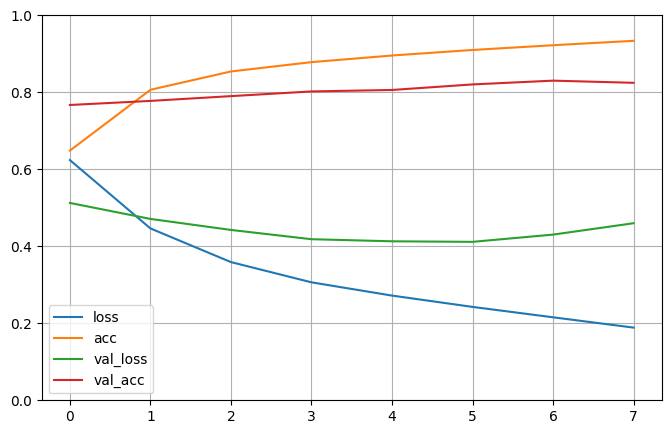

In [46]:
# Plot training history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

# ‽ Uppgift
Sekvenslängd och mask
* Notera vilken testnoggrannhet du får för detta fall \
Svar: 0.777
* Gå nu upp och ändra sequence_length till 500, vilken testnoggrannhet får du då? Vad kan vara skälet till detta beteende? \
Svar: får 0.5 ungefär (lite olika varje gång). Early stopping aktiveras tidigt, så resultatet är från en väldigt tidig epoch.
* Pröva sedan med att sätta 'mask_zero=True' i Embedding-lagret \
Svar: Får en nogrannhet på 0.871.
* Kompletera sedan bilden med att köra med 'mask_zero=True' och sequence_length=100 \
Svar: Får en nogrannhet på 0.784.

* Titta även på träningskurvorna, går det fort för modellen att överträna? Vad händer om du halverar learning_rate (med träningstid, testnoggrannhet, träningskurvorna)? \
Svar: Ja. Det går snabbt. Därför early stopping aktiveras så tidigt. \
Med en halverad learning rate går nogrannheten från 0.784 till 0.804. Mängden epochs som körs innan early stopping aktiveras ökade också. Det tyder på att det tar längr tid för modellen att överträna (grafen stöder detta). Tiden det tog att träna modellen gick även upp (56.9s till 90.2s). Detta är rimligt med tanke på den ökade mängden epochs.

[...]

## A concrete LSTM example in Keras

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network,
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you
having to spend time tuning parameters by hand.

In [110]:
model = keras.Sequential([
    keras.Input(shape=(None,), dtype="int32"),
    keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.LSTM(128, return_sequences=False),
    keras.layers.Dense(1,activation='sigmoid')
],name='LSTM32')

In [111]:
model.summary()

Model: "LSTM32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_38 (Embedding)             │ (None, None, 32)            │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, None, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_44 (LSTM)                       │ (None, 128)                 │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 402,689 (1.54 MB)

 Trainable params: 402,625 (1.54 MB)

 Non-trainable params: 64 (256.00 B)

In [112]:
import time
model,history = compile_and_fit(model,patience=2)

Training LSTM32
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 106s 166ms/step - acc: 0.6423 - loss: 0.6112 - val_acc: 0.7946 - val_loss: 0.4855
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 234ms/step - acc: 0.8258 - loss: 0.3974 - val_acc: 0.8166 - val_loss: 0.4213
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 91s 145ms/step - acc: 0.8597 - loss: 0.3347 - val_acc: 0.8154 - val_loss: 0.4468
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 90s 144ms/step - acc: 0.8823 - loss: 0.2956 - val_acc: 0.8154 - val_loss: 0.4759
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.
Time to run: 434.0


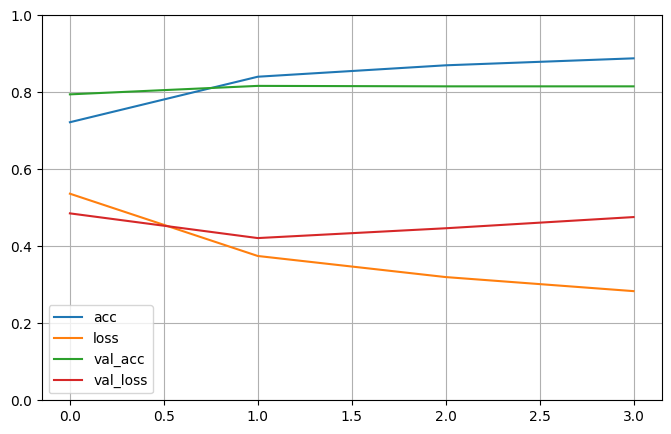

In [113]:
# Plot training history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [114]:
test_loss, test_acc =  model.evaluate(test_ds, verbose=0)
print(f'Model {model.name}, len={sequence_length}, test accuracy: {test_acc:.3f}')

Model LSTM32, len=500, test accuracy: 0.807


## Testing with Test sentences

In [115]:
# See what the model say about the test sentences
tspred = model.predict(preprocessing_layer(test_sentences))
for ix in range(len(tspred)):
  print(f'{tspred[ix,0]:.2f} -- {test_sentences[ix]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
0.15 -- That movie was absolutely awful
0.43 -- The acting was a bit lacking
0.66 -- The film was creative and surprising
0.64 -- Absolutely fantastic!
0.44 -- This movie is not worth the money
0.44 -- The only positive thing with this movie is the music


# ‽ Uppgift
Utforska fler LSTM modeller (Om du får problem med körtiderna så kan du för denna del använda sekvenslängd 100 och bara för den absolut bästa modellen köra en gång med längd 500 så vi får något att jämföra med i följande delar).
* LSTM(128) med 128 noder, Två lager av LSTM(2L32), en en bidirektionell LSTM BiLSTM(32) och analysera dessa resultat. \
original ger nogrannhet på 0.813 \
LSTM(128) ger nogrannhet på 0.816 \
LSTM(2L32) ger nogrannhet på 0.813 \
Bidirectional ger nogrannhet på 0.811 \
Fler noder hjälpte med att få en högre nogrannhet. Dubbla LSTM(32) lager gav samma resultat som med ett. Bidirectional drog ner nogrannheten lite.

* Hitta en "bästa" modell att gå vidare med. \
Svar: Min bästa modell har 128 noder. (den ger nogrannhet på 0.811 med längd 500.
* Undersök ifall det finns någon regularisering som förbättrar testnoggrannheten (notera att det finns speciella regulariseringar för LSTM modeller som du också kan pröva). \
Svar: Testade med ett BatchNormalization lager. Det gav en nogrannhet 0.807 (vilket är lägre än tidigare). Däremot gav det mer jämna resultat för testmeningarna. Väljer därför att ha kvar det.

* Testa din bästa RNN-modell på våra testmeningar, finns det några meningar som modellen är osäker på, och i så fall, är det förståeligt? \
Svar: Den har problem med första meningen "That movie was absolutly awful!". Verkar inte som att den vriktigt et vad den ska göra med "absolutly". Kan ha att göra med att ordet kan ses som positivt. De andra meningarna är den mycket mer säker på.


# Test a CNN Model
How good would a CNN model be on this problem?

## Set up a CNN model and train

In [116]:
embedding_dim = 32

In [117]:
# A integer input for vocab indices.
inputs = keras.Input(shape=(None,), dtype="int32")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = keras.layers.Embedding(vocab_size, embedding_dim)(inputs)
x = keras.layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = keras.layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = keras.layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = keras.Model(inputs, predictions,name='CNN')

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [118]:
epochs = 3

# Fit the model using the train and test datasets.
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.5956 - loss: 0.6305 - val_accuracy: 0.8064 - val_loss: 0.4178
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.8307 - loss: 0.3847 - val_accuracy: 0.8168 - val_loss: 0.4040
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.8841 - loss: 0.2944 - val_accuracy: 0.8238 - val_loss: 0.4341


In [119]:
test_loss, test_acc =  model.evaluate(test_ds, verbose=0)
print(f'Model {model.name}, len={sequence_length}, test accuracy: {test_acc:.3f}')

Model CNN, len=500, test accuracy: 0.798


In [120]:
# See what the model say about the test sentences
tspred = model.predict(preprocessing_layer(test_sentences))
for ix in range(len(tspred)):
  print(f'{tspred[ix,0]:.2f} -- {test_sentences[ix]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
0.09 -- That movie was absolutely awful
0.45 -- The acting was a bit lacking
0.74 -- The film was creative and surprising
0.85 -- Absolutely fantastic!
0.54 -- This movie is not worth the money
0.57 -- The only positive thing with this movie is the music


# ‽ Uppgift
* Jämför din (bästa) LSTM-modell med denna CNN-modell, vilka slutsatser drar du? \
Svar: Nogrannheten är lägre på 0.798. Dessutom har den ännu svårare för första meningen än vad RNN-modellen hade. Hur säker den är på de olika meningarna varierar dessutom mer (även om detta antagligen beror på batch-normalization lagret). Kort sagt skulle jag lägga mer vikt vid RNN-modellens resultat än CNN-modellens.

# Now testing with BERT using Keras NLP
https://keras.io/guides/keras_nlp/getting_started/

In [14]:
import keras_nlp
print('KerasNLP version:', keras_nlp.__version__)

# Read all the possible parts for a pretrained model
# https://keras.io/api/keras_nlp/models/

model_name = "bert_small_en_uncased"
#model_name = "bert_tiny_en_uncased"

print(f'Using {model_name}')
classifier   = keras_nlp.models.BertClassifier.from_preset(model_name, num_classes=2)
backbone     = keras_nlp.models.BertBackbone.from_preset(model_name)
tokenizer    = keras_nlp.models.BertTokenizer.from_preset(model_name)
preprocessor = keras_nlp.models.BertPreprocessor.from_preset(model_name)

KerasNLP version: 0.10.0.dev2024050703
Using bert_small_en_uncased


100%|██████████| 508/508 [00:00<00:00, 567kB/s]
100%|██████████| 110M/110M [00:08<00:00, 14.0MB/s]
100%|██████████| 547/547 [00:00<00:00, 513kB/s]
100%|██████████| 226k/226k [00:00<00:00, 295kB/s]


## Read data into datasets

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Use the raw datasets as BERT has its own preprocessing and tokenizer
imdb_train = raw_imdb_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
imdb_val   = raw_imdb_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
imdb_test  = raw_imdb_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
# Inspect first review
# Format is (review text tensor, label tensor)
print(imdb_train.unbatch().take(1).get_single_element())

(<tf.Tensor: shape=(), dtype=string, numpy=b'I rented this horrible movie. The worst think I have ever seen. I believe a 1st grade class could have done a better job. The worse film I have ever seen and I have seen some bad ones. Nothing scary except I paid 1.50 to rent it and that was 1.49 too much. The acting is horrible, the characters are worse and the film is just a piece of trash. The slauther house scenes are so low budget that it makes a B movied look like an Oscar candidate. All I can say is if you wnat to waste a good evening and a little money go rent this horrible flick. I would rather watch killer clowns from outer space while sitting in a bucket of razors than sit through this flop again'>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)


## Use the BERT classifier  (contains both preprocessor and backbone)

https://keras.io/api/keras_nlp/models/bert/bert_classifier/

In [18]:
classifier   = keras_nlp.models.BertClassifier.from_preset(model_name, num_classes=2)
import time
start = time.time()
classifier.fit(
    imdb_train,
    validation_data=imdb_val,
    epochs=2,
)
end = time.time()
print(f"Time to run: {end - start:.1f}",)
# Take approximately 780s on a T4

Epoch 1/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 417s 649ms/step - loss: 0.3957 - sparse_categorical_accuracy: 0.8108 - val_loss: 0.2601 - val_sparse_categorical_accuracy: 0.8982
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 370s 585ms/step - loss: 0.1867 - sparse_categorical_accuracy: 0.9290 - val_loss: 0.2861 - val_sparse_categorical_accuracy: 0.8946
Time to run: 790.3


In [19]:
test_loss, test_acc =  classifier.evaluate(imdb_test, verbose=0)
print(f'Model {classifier.name} test accuracy: {test_acc:.3f}')

Model bert_classifier_2 test accuracy: 0.898


In [20]:
tspred = classifier.predict(test_sentences, verbose=0)
for ix in range(len(tspred)):
  sm =keras.activations.softmax(tspred[ix])
  print(f'{sm[1]:.2f} -- {test_sentences[ix]}')

0.00 -- That movie was absolutely awful
0.04 -- The acting was a bit lacking
0.89 -- The film was creative and surprising
1.00 -- Absolutely fantastic!
0.09 -- This movie is not worth the money
0.18 -- The only positive thing with this movie is the music


In [21]:
classifier.summary()

Preprocessor: "bert_preprocessor_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 512), (None,      │      28,763,648 │ padding_mask[0][0],        │
│                               │ None, 512)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 512)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,026 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 86,294,024 (329.19 MB)

 Trainable params: 28,764,674 (109.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 57,529,350 (219.46 MB)

# ‽ Uppgift
* Jämför dina tidigare modeller mot denna BERT vilka slutsatser drar du? \
Denna modell har en högre nogrannhet på 0.898. Hur säker den är på testmeningarna varierar ännu mer än CNN-modellen. Mening 1 är den inte alls säker på (0.00) medan den är helt säker på mening 4 (1.00). Så stora intervaller hade ingen av de tidigare modellerna.

# VG uppgifter

### För LSTM
**Eftersom det strular med Keras och Keras-NLP versioner för hur man sätter up sin egen version av vikter för Embedding och att det dessutom verkar använda upp väldigt mycket minne så låter vi den delen av VG-delen utgå.**

För den basala LSTM(32) modellen, ersätt det vanliga embedding lagret med en förtränad word2vec modell och undersök om detta kan leda till bättre prestanda.
* Implementera en överförd inlärnings av våra RNNs Embedding lager
* Analysera och utvärdera

### För BERT
Istället för att använda den färdiga BertClassfier så ska du här använda BERTBackbone med överförd inlärning. Nedan ger jag ett exempel. Om det blir för långa körtider kan du byta modell till "bert_tiny_en_uncased"
* Din uppgift är att undersök om du kan hitta några egna "top" lager som förbättrar denna BERT-modell.

# Now work with BERT model backbone more directly
Based on
https://keras.io/guides/keras_nlp/getting_started/

In [ ]:
# If we only use the backbone, we need to preprocess our data
imdb_train_preprocessed = (
    imdb_train.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
)
imdb_val_preprocessed = (
    imdb_val.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
)
imdb_test_preprocessed = (
    imdb_test.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
)

In [ ]:
def bert_compile_and_fit(model, epochs=15, patience=2):
  model.compile(
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer=keras.optimizers.AdamW(5e-5),
      metrics=[keras.metrics.SparseCategoricalAccuracy()],
      jit_compile=True,
  )

  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                                verbose=1, patience=patience,
                                                restore_best_weights = True)

  start = time.time()
  history = model.fit(
      imdb_train_preprocessed,
      validation_data=imdb_val_preprocessed,
      epochs=epochs,
      callbacks=[early_stopping]
  )
  end = time.time()
  print(f"Time to run: {end - start:.1f}",)
  return model,history

## Only train top (everything after backbone)

In [ ]:
# Now Do Not train backbone
backbone.trainable = False

# Set up model using transfer learning of backbone
inputs = backbone.input
# There are multiple parts as output from backbone, but this was difficult to figure out before
# the example in https://keras.io/guides/keras_nlp/getting_started/
sequence = backbone(inputs)["sequence_output"]
for _ in range(2):
    sequence = keras_nlp.layers.TransformerEncoder(
        num_heads=2,
        intermediate_dim=512,
        dropout=0.1,
    )(sequence)

# Note that if you want your own layers here then its input should be (sequence[:, backbone.cls_token_index, :])
x = keras.layers.Dense(2)(sequence[:, backbone.cls_token_index, :])

model = keras.Model(inputs=inputs, outputs=x, name = f'{model_name}-basic_backbone-only_top_train')
model.summary()

Model: "bert_small_en_uncased-basic_backbone-only_top_train"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer) │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ segment_ids (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_ids (InputLayer)    │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_backbone             │ [(None, 512), (None,   │     28,763,648 │ padding_mask[0][0],    │
│ (BertBackbone)            │ None, 512)]            │                │ segment_ids[0][0],     │
│                           │                        │                │ token_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder       │ (None, None, 512)      │      1,577,984 │ bert_backbone[0][1]    │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_1     │ (None, None, 512)      │      1,577,984 │ transformer_encoder[0… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 512)            │              0 │ transformer_encoder_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 2)              │          1,026 │ get_item_3[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 31,920,642 (121.77 MB)

 Trainable params: 3,156,994 (12.04 MB)

 Non-trainable params: 28,763,648 (109.72 MB)

In [ ]:
model,history = bert_compile_and_fit(model)
# Takes approximately 1560s (ES on epoch 6) on a T4

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 301s 471ms/step - loss: 0.5008 - sparse_categorical_accuracy: 0.7521 - val_loss: 0.3412 - val_sparse_categorical_accuracy: 0.8486
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 239s 377ms/step - loss: 0.3224 - sparse_categorical_accuracy: 0.8658 - val_loss: 0.3532 - val_sparse_categorical_accuracy: 0.8480
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 296s 475ms/step - loss: 0.2941 - sparse_categorical_accuracy: 0.8810 - val_loss: 0.3260 - val_sparse_categorical_accuracy: 0.8614
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 296s 474ms/step - loss: 0.2751 - sparse_categorical_accuracy: 0.8882 - val_loss: 0.3262 - val_sparse_categorical_accuracy: 0.8624
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 236s 378ms/step - loss: 0.2620 - sparse_categorical_accuracy: 0.8929 - val_loss: 0.2972 - val_sparse_categorical_accuracy: 0.8740
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 236s 377ms/step - loss: 0.2453 - sparse_categorical_accuracy: 0.9026 - val_loss: 0.3014 - val_sparse_categoric

In [ ]:
test_loss, test_acc =  model.evaluate(imdb_test_preprocessed, verbose=0)
print(f'Model {model.name} test accuracy: {test_acc:.3f}')

Model bert_small_en_uncased-basic_backbone-only_top_train test accuracy: 0.890


In [ ]:
# See what the model say about the test sentences
tspred = model.predict(preprocessor(test_sentences), verbose=0)
for ix in range(len(tspred)):
  sm =keras.activations.softmax(tspred[ix])
  print(f'{sm[1]:.2f} -- {test_sentences[ix]}')

0.07 -- That movie was absolutely awful
0.13 -- The acting was a bit lacking
0.95 -- The film was creative and surprising
0.97 -- Absolutely fantastic!
0.17 -- This movie is not worth the money
0.52 -- The only positive thing with this movie is the music
